In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [14]:
data_dir = 'Train'


img_height = 360
img_width = 360
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.


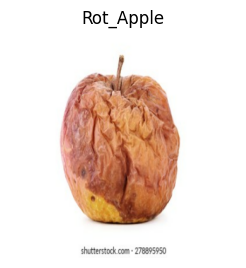

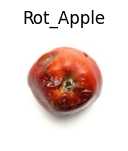

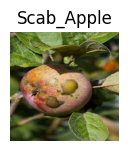

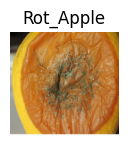

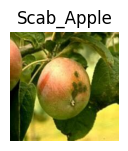

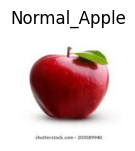

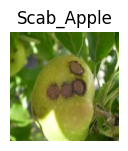

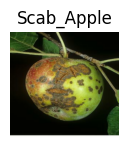

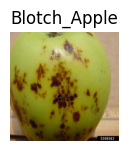

In [15]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    plt.show()


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [30]:
model = keras.models.Sequential()

model.add(layers.Input(shape=(360, 360, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.1))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(4))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 358, 358, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 179, 179, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 177, 177, 64)      73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 88, 88, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 43, 64)      

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 358, 358, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 179, 179, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 177, 177, 64)      73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 88, 88, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 43, 64)      

In [33]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 51s 5s/step - loss: 11.3169 - accuracy: 0.2712 - val_loss: 5.6974 - val_accuracy: 0.2632
Epoch 2/10
10/10 [==============================] - 49s 5s/step - loss: 2.3568 - accuracy: 0.3072 - val_loss: 1.3483 - val_accuracy: 0.4211
Epoch 3/10
10/10 [==============================] - 49s 5s/step - loss: 1.3149 - accuracy: 0.4150 - val_loss: 1.2291 - val_accuracy: 0.4737
Epoch 4/10
10/10 [==============================] - 50s 5s/step - loss: 1.1122 - accuracy: 0.5817 - val_loss: 0.9903 - val_accuracy: 0.6711
Epoch 5/10
10/10 [==============================] - 50s 5s/step - loss: 0.9323 - accuracy: 0.6405 - val_loss: 1.1365 - val_accuracy: 0.5789
Epoch 6/10
10/10 [==============================] - 50s 5s/step - loss: 0.9320 - accuracy: 0.6111 - val_loss: 0.9990 - val_accuracy: 0.6184
Epoch 7/10
10/10 [==============================] - 53s 5s/step - loss: 0.8072 - accuracy: 0.7222 - val_loss: 0.8398 - val_accuracy: 0.6974
Epoch 8/10
10/10 [=